In [20]:
import os
import pandas as pd
import math
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas as gpd
import gdal
import geopandas as gpd
import descartes 
from shapely.geometry import Point, Polygon
from shapely import wkt


import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
import fiona
import re
#os.chdir('../../')
#os.chdir('../')

os.getcwd()






'C:\\Users\\lgorman\\OneDrive\\Desktop\\PhD\\Analysis'

In [91]:
def remove_outliers_with_interquartile_range(column):
    quartile_1=column.quantile(0.25)
    quartile_3=column.quantile(0.75)
    interquartile_range=quartile_3-quartile_1
    
    lower_limit=quartile_1-1.5*interquartile_range
    upper_limit=quartile_3+1.5*interquartile_range
    
    column=column[(column>lower_limit) & (column<upper_limit)]
    return column;


In [4]:
data=gpd.read_file(os.path.join('data',"processed","points_within_grids_within_countries_100km.geojson"), driver='GeoJSON') # at this point we only preserve the grid geometry. Will need to add point geometry when reading the file back in again (same with country boundaries)  
data.columns=["geometry_grid" if column_names=="geometry" else column_names for column_names in data.columns]



In [5]:
world_shapefile=gpd.read_file(os.path.join('data',"shapefiles","World")) # at this point we only preserve the grid geometry. Will need to add point geometry when reading the file back in again (same with country boundaries)  


In [6]:
geometry=[Point(xy) for xy in zip(data["GPS_LON"], data["GPS_LAT"])]
crs={'init' :'epsg:4326'}
data = gpd.GeoDataFrame(data, geometry=geometry,crs=crs)

In [7]:
data.columns

Index(['OBJECTID_grid', 'CNTRY_NAME', 'Unnamed: 0', 'FID', 'mean_education',
       'median_education', 'std_education', 'majority',
       'mean_technological_capital', 'median_technological_capital',
       ...
       'Livestock_Orientation', 'Food_Availability_kCal_MAE_day',
       'Food_Self_Sufficiency_kCal_MAE_day', 'NrofMonthsWildFoodCons',
       'GHGEmissions', 'Gender_MaleControl', 'Gender_FemaleControl',
       'NFertInput', 'geometry_grid', 'geometry'],
      dtype='object', length=122)

In [8]:
data=data.drop(columns=["Unnamed: 0", "OBJECTID_grid"])

In [9]:
data.columns= ["geometry_point" if column=="geometry" else column for column in data.columns]

In [10]:
cols_to_merge = ["CNTRY_NAME","geometry"]
data=pd.merge(data, world_shapefile[cols_to_merge], how="inner",on="CNTRY_NAME", suffixes=["",""])
data.columns=["geometry_country" if column_names=="geometry" else column_names for column_names in data.columns]


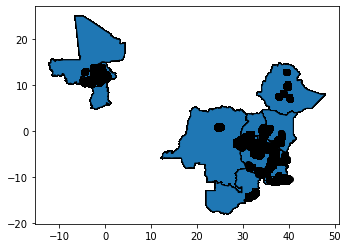

In [11]:
fig,ax=plt.subplots()
data.set_geometry("geometry_country").plot(ax=ax, edgecolor="black",color=None)
data.set_geometry("geometry_grid").plot(ax=ax, edgecolor="black",color=None)
data.set_geometry("geometry_point").plot(ax=ax, color="black")
plt.show()

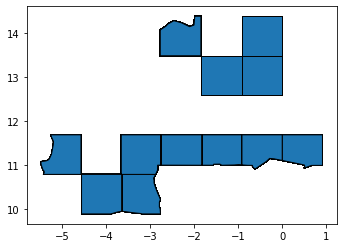

In [12]:
data.loc[1:1000,:].set_geometry("geometry_grid").plot(edgecolor="black")

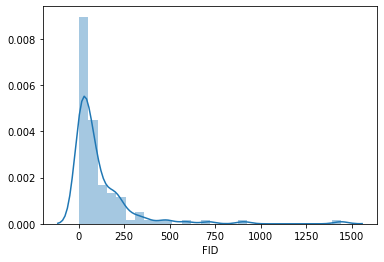

In [13]:
households_per_grid=data["FID"].value_counts()
sns.distplot(households_per_grid)

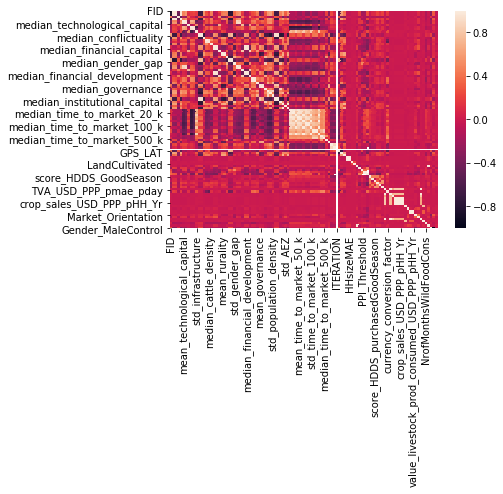

In [14]:
correlations=data.corr()
sns.heatmap(correlations)

In [15]:
correlations.loc["Food_Availability_kCal_MAE_day","mean_education"]

-0.01741060653082137

In [16]:
correlating_values=[]
for columns in correlations.columns:
    for rows in correlations.index:
        individual_correlation=correlations.loc[rows,columns]
        if abs(individual_correlation)>0.2:
            if columns!=rows:
                correlating_values.append(columns+" "+rows)

In [61]:
geograhic_columns_pattern=["FID", "std_", "median_", "mean_", "majority_"]
all_columns=data.columns
def find_and_return_existing_patterns(pattern,item_to_check):
    test=re.search(pattern,item_to_check)
    if test is not None:
        return item_to_check;
    if test is None:
        return None;

def grouping_pattern_in_list(pattern, list_to_check):
    list_of_matches=[]
    [list_of_matches.append(find_and_return_existing_patterns(pattern=pattern,item_to_check=item_to_check))  for item_to_check in list_to_check  if find_and_return_existing_patterns(pattern=pattern,item_to_check=item_to_check) is not None]
    return list_of_matches;

def grouping_multiple_patterns_in_list(list_of_patterns, list_to_check):
    list_of_matches=[]
    [list_of_matches.append(grouping_pattern_in_list(pattern=pattern, list_to_check=list_to_check))  for pattern in list_of_patterns]
    unnested_list=[]
    
    for sublist in range(len(list_of_matches)):
        temp_list=list_of_matches[sublist]
        for item_in_sublist in temp_list:
            unnested_list.append(item_in_sublist)        
    return unnested_list;

geographic_columns=grouping_multiple_patterns_in_list(list_of_patterns=geograhic_columns_pattern, list_to_check=all_columns)


In [62]:
geographic_columns

['FID',
 'std_education',
 'std_technological_capital',
 'std_infrastructure',
 'std_conflictuality',
 'std_cattle_density',
 'std_financial_capital',
 'std_rurality',
 'std_gender_gap',
 'std_household_technological_capital',
 'std_financial_development',
 'std_richness',
 'std_governance',
 'std_population_density',
 'std_institutional_capital',
 'std_AEZ',
 'std_time_to_market_20_k',
 'std_time_to_market_50_k',
 'std_time_to_market_100_k',
 'std_time_to_market_250_k',
 'std_time_to_market_500_k',
 'median_education',
 'median_technological_capital',
 'median_infrastructure',
 'median_conflictuality',
 'median_cattle_density',
 'median_financial_capital',
 'median_rurality',
 'median_gender_gap',
 'median_household_technological_capital',
 'median_financial_development',
 'median_richness',
 'median_governance',
 'median_population_density',
 'median_institutional_capital',
 'median_AEZ',
 'median_time_to_market_20_k',
 'median_time_to_market_50_k',
 'median_time_to_market_100_k',
 '

In [71]:
columns_in_geographic_columns=list(map(lambda x: x in geographic_columns, list(data.columns)))

In [74]:
geographic_data=data.loc[:,columns_in_geographic_columns]

In [77]:
geographic_data.head()

,FID,mean_education,median_education,std_education,mean_technological_capital,median_technological_capital,std_technological_capital,mean_infrastructure,median_infrastructure,std_infrastructure,...,std_time_to_market_50_k,mean_time_to_market_100_k,median_time_to_market_100_k,std_time_to_market_100_k,mean_time_to_market_250_k,median_time_to_market_250_k,std_time_to_market_250_k,mean_time_to_market_500_k,median_time_to_market_500_k,std_time_to_market_500_k
0,9585.0,-0.49736,-0.466796,0.083003,-0.369775,-0.278394,0.315031,0.029652,0.289045,0.767505,...,3.851765,5.818812,4.571875,3.660413,6.240825,5.026165,3.701301,6.776385,5.73608,3.51822
1,9585.0,-0.49736,-0.466796,0.083003,-0.369775,-0.278394,0.315031,0.029652,0.289045,0.767505,...,3.851765,5.818812,4.571875,3.660413,6.240825,5.026165,3.701301,6.776385,5.73608,3.51822
2,9585.0,-0.49736,-0.466796,0.083003,-0.369775,-0.278394,0.315031,0.029652,0.289045,0.767505,...,3.851765,5.818812,4.571875,3.660413,6.240825,5.026165,3.701301,6.776385,5.73608,3.51822
3,9585.0,-0.49736,-0.466796,0.083003,-0.369775,-0.278394,0.315031,0.029652,0.289045,0.767505,...,3.851765,5.818812,4.571875,3.660413,6.240825,5.026165,3.701301,6.776385,5.73608,3.51822
4,9585.0,-0.49736,-0.466796,0.083003,-0.369775,-0.278394,0.315031,0.029652,0.289045,0.767505,...,3.851765,5.818812,4.571875,3.660413,6.240825,5.026165,3.701301,6.776385,5.73608,3.51822


In [84]:

columns_in_other_data=[item==False for item in columns_in_geographic_columns]
original_rhomis_data=data.loc[:,columns_in_other_data]

In [85]:
original_rhomis_data.head()

,CNTRY_NAME,majority,OBJECTID_country,index_right,ID_PROJ,ID_COUNTRY,YEAR,ITERATION,SURVEY_ID,ID_HH,...,Food_Availability_kCal_MAE_day,Food_Self_Sufficiency_kCal_MAE_day,NrofMonthsWildFoodCons,GHGEmissions,Gender_MaleControl,Gender_FemaleControl,NFertInput,geometry_grid,geometry_point,geometry_country
0,Burkina Faso,-0.573681,234,11637,TA5,BF,2018,1,BF_TA5_2018,BF_2018_TA5_411_1,...,1780.397812,1780.397812,0,166.88,1.000000,0.000000,200.0,"POLYGON ((0.91551 10.99641, 0.81194 10.99694, ...",POINT (0.07000 11.66000),"POLYGON ((0.91797 10.99640, 0.81194 10.99694, ..."
1,Burkina Faso,-0.573681,234,11638,TA5,BF,2018,1,BF_TA5_2018,BF_2018_TA5_412_1,...,2229.041096,2229.041096,0,125.16,1.000000,0.000000,150.0,"POLYGON ((0.91551 10.99641, 0.81194 10.99694, ...",POINT (0.07000 11.66000),"POLYGON ((0.91797 10.99640, 0.81194 10.99694, ..."
2,Burkina Faso,-0.573681,234,11639,TA5,BF,2018,1,BF_TA5_2018,BF_2018_TA5_413_1,...,3775.476111,3775.476111,0,125.16,1.000000,0.000000,150.0,"POLYGON ((0.91551 10.99641, 0.81194 10.99694, ...",POINT (0.07000 11.65000),"POLYGON ((0.91797 10.99640, 0.81194 10.99694, ..."
3,Burkina Faso,-0.573681,234,11640,TA5,BF,2018,1,BF_TA5_2018,BF_2018_TA5_414_1,...,1179.386823,1179.386823,0,250.32,1.000000,0.000000,300.0,"POLYGON ((0.91551 10.99641, 0.81194 10.99694, ...",POINT (0.07000 11.65000),"POLYGON ((0.91797 10.99640, 0.81194 10.99694, ..."
4,Burkina Faso,-0.573681,234,11641,TA5,BF,2018,1,BF_TA5_2018,BF_2018_TA5_415_1,...,383577.617927,2831.855120,0,488.72,0.521012,0.478988,300.0,"POLYGON ((0.91551 10.99641, 0.81194 10.99694, ...",POINT (0.08000 11.65000),"POLYGON ((0.91797 10.99640, 0.81194 10.99694, ..."


In [86]:
correlations_indicators=original_rhomis_data.corr()

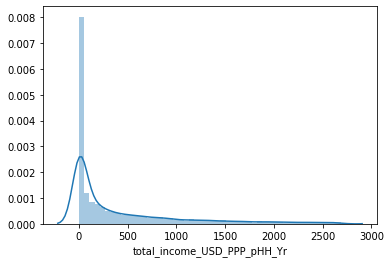

In [93]:
sns.distplot(remove_outliers_with_interquartile_range(original_rhomis_data["total_income_USD_PPP_pHH_Yr"]))

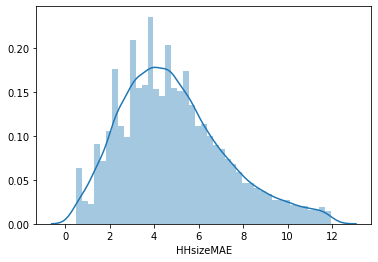

In [94]:
sns.distplot(remove_outliers_with_interquartile_range(original_rhomis_data["HHsizeMAE"]))

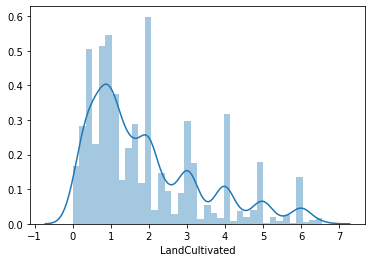

In [95]:
sns.distplot(remove_outliers_with_interquartile_range(original_rhomis_data["LandCultivated"]))

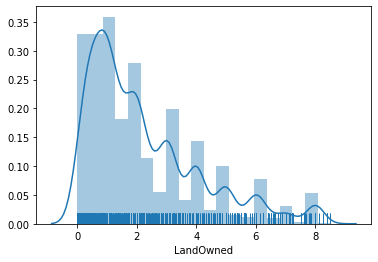

In [105]:
sns.distplot(remove_outliers_with_interquartile_range(original_rhomis_data["LandOwned"]), bins=20, rug=True)

In [109]:
geographic_data

,FID,mean_education,median_education,std_education,mean_technological_capital,median_technological_capital,std_technological_capital,mean_infrastructure,median_infrastructure,std_infrastructure,...,std_time_to_market_50_k,mean_time_to_market_100_k,median_time_to_market_100_k,std_time_to_market_100_k,mean_time_to_market_250_k,median_time_to_market_250_k,std_time_to_market_250_k,mean_time_to_market_500_k,median_time_to_market_500_k,std_time_to_market_500_k
0,9585.0,-0.497360,-0.466796,0.083003,-0.369775,-0.278394,0.315031,0.029652,0.289045,0.767505,...,3.851765,5.818812,4.571875,3.660413,6.240825,5.026165,3.701301,6.776385,5.73608,3.518220
1,9585.0,-0.497360,-0.466796,0.083003,-0.369775,-0.278394,0.315031,0.029652,0.289045,0.767505,...,3.851765,5.818812,4.571875,3.660413,6.240825,5.026165,3.701301,6.776385,5.73608,3.518220
2,9585.0,-0.497360,-0.466796,0.083003,-0.369775,-0.278394,0.315031,0.029652,0.289045,0.767505,...,3.851765,5.818812,4.571875,3.660413,6.240825,5.026165,3.701301,6.776385,5.73608,3.518220
3,9585.0,-0.497360,-0.466796,0.083003,-0.369775,-0.278394,0.315031,0.029652,0.289045,0.767505,...,3.851765,5.818812,4.571875,3.660413,6.240825,5.026165,3.701301,6.776385,5.73608,3.518220
4,9585.0,-0.497360,-0.466796,0.083003,-0.369775,-0.278394,0.315031,0.029652,0.289045,0.767505,...,3.851765,5.818812,4.571875,3.660413,6.240825,5.026165,3.701301,6.776385,5.73608,3.518220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13797,11172.0,-0.483982,-0.416573,0.108814,0.076249,0.076965,0.081266,0.343051,0.366604,0.169796,...,0.779941,3.748286,3.659900,0.829172,4.580369,4.598420,0.840100,5.350113,5.28459,0.798556
13798,11172.0,-0.483982,-0.416573,0.108814,0.076249,0.076965,0.081266,0.343051,0.366604,0.169796,...,0.779941,3.748286,3.659900,0.829172,4.580369,4.598420,0.840100,5.350113,5.28459,0.798556
13799,11172.0,-0.483982,-0.416573,0.108814,0.076249,0.076965,0.081266,0.343051,0.366604,0.169796,...,0.779941,3.748286,3.659900,0.829172,4.580369,4.598420,0.840100,5.350113,5.28459,0.798556
13800,11172.0,-0.483982,-0.416573,0.108814,0.076249,0.076965,0.081266,0.343051,0.366604,0.169796,...,0.779941,3.748286,3.659900,0.829172,4.580369,4.598420,0.840100,5.350113,5.28459,0.798556
